# Visualize results from anova, significant units

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

### Load significant units for response/choice interaction

In [2]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]

good_int_res = io_utils.read_anova_good_units(args, "99th")
good_int_res.PseudoUnitID.nunique()

212

In [3]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))

In [8]:
unit_pos[["structure_level2", "structure_level3"]].sort_values(by="structure_level2")[:100]

structure_level2                 structure_level3
29                   amygdala (Amy)          pallial_amygdala (pAmy)
4                    amygdala (Amy)          pallial_amygdala (pAmy)
0                    amygdala (Amy)          pallial_amygdala (pAmy)
20                   amygdala (Amy)          pallial_amygdala (pAmy)
5                    amygdala (Amy)          pallial_amygdala (pAmy)
..                              ...                              ...
30  anterior_cingulate_gyrus (ACgG)  anterior_cingulate_cortex (ACC)
32  anterior_cingulate_gyrus (ACgG)  anterior_cingulate_cortex (ACC)
7   anterior_cingulate_gyrus (ACgG)  anterior_cingulate_cortex (ACC)
6   anterior_cingulate_gyrus (ACgG)  anterior_cingulate_cortex (ACC)
5   anterior_cingulate_gyrus (ACgG)  anterior_cingulate_cortex (ACC)

[100 rows x 2 columns]

### Plots for interaction units (without rasters)

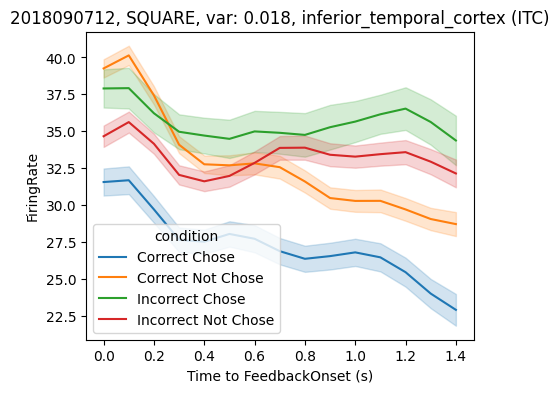

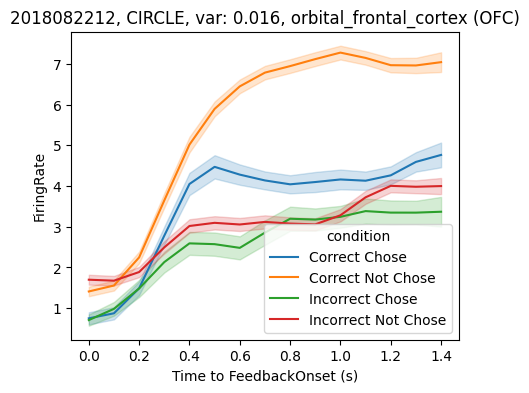

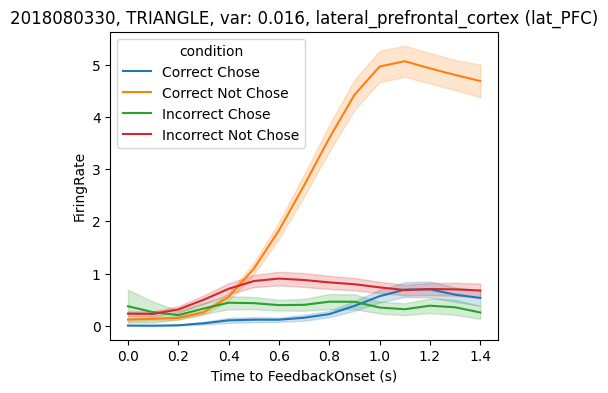

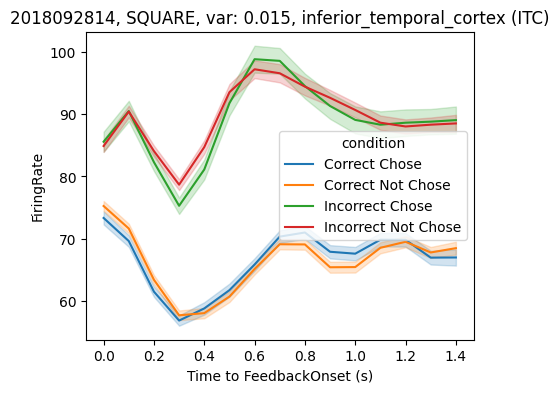

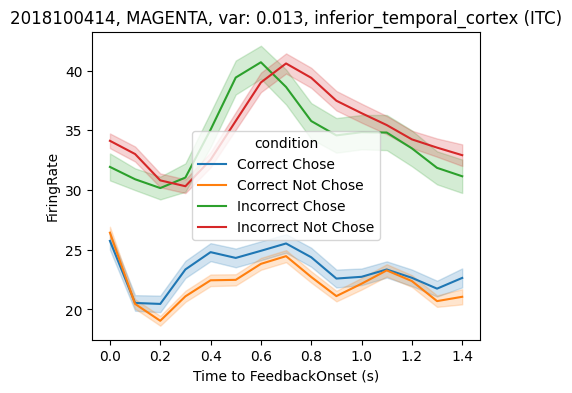

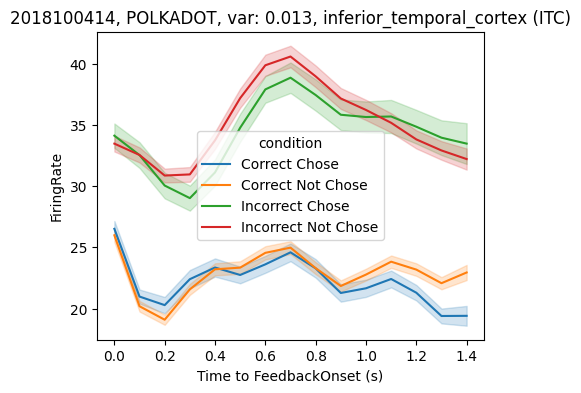

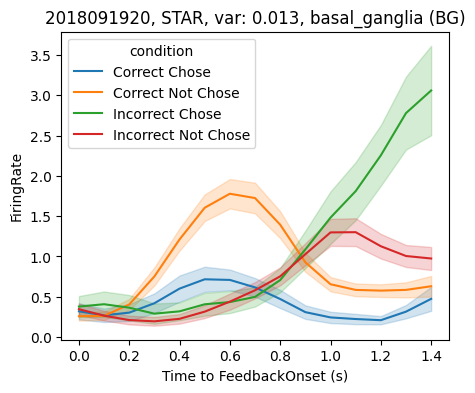

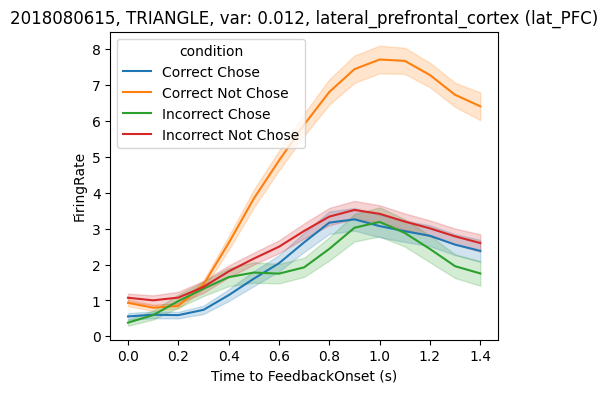

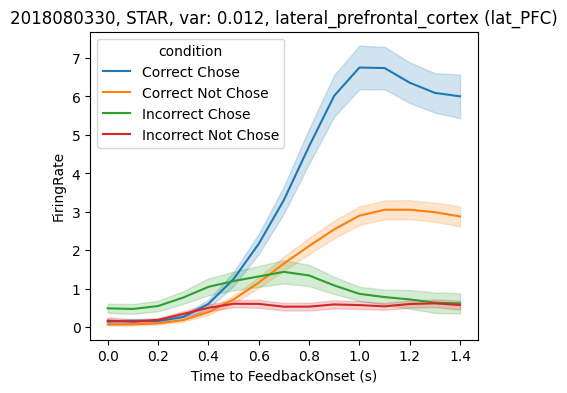

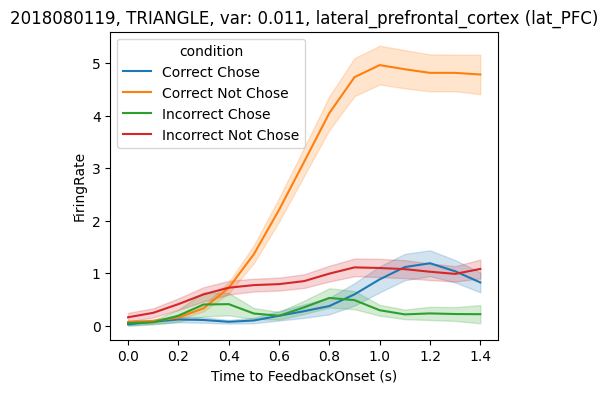

In [4]:
to_vis = good_int_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    session = int(unit_id / 100)
    beh, frs = load_data(session, args, return_merged=False)
    frs = frs[frs.PseudoUnitID == unit_id]
    beh["condition"] = beh.apply(lambda x: " ".join([x[cond] for cond in args.conditions]), axis=1)
    order = np.sort(beh["condition"].unique())


    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.lineplot(pd.merge(frs, beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="condition", hue_order=order, ax=ax)
    ax.set_xlabel("Time to FeedbackOnset (s)")
    ax.set_title(f"{unit_id}, {unit.feat}, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

In [ ]:
to_vis = good_int_res.sort_values("combined_fracvar", ascending=False)[:5]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    session = int(unit_id / 100)
    beh, frs = load_data(session, args, return_merged=False)
    frs = frs[frs.PseudoUnitID == unit_id]
    beh["condition"] = beh.apply(lambda x: " ".join([x[cond] for cond in args.conditions]), axis=1)


    # unit_frs["FeatPreferred"] = unit_frs["PreferredBelief"].apply(lambda x: x == feat)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
    sns.lineplot(pd.merge(frs, beh, on="TrialNumber"), x="TimeBins", y="FiringRate", errorbar="se", hue="condition", ax=ax1)
    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")
    if args.time_range is not None: 
        trial_interval = TrialInterval(args.trial_interval.event, args.time_range[0], args.time_range[1], args.trial_interval.interval_size)
    else: 
        trial_interval = args.trial_interval
    visualization_utils.visualize_unit_raster("SA", session, unit_id, beh, trial_interval, ax2)

### Visualize a few for preferred/not preferred, conditioning on choosing the feature, getting it correct, and the preferred feature being on the chosen card

In [10]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [0, 1500]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_res = io_utils.read_anova_good_units(args, "99th")


In [11]:
good_pref_res.PseudoUnitID.nunique()

164

<Axes: >

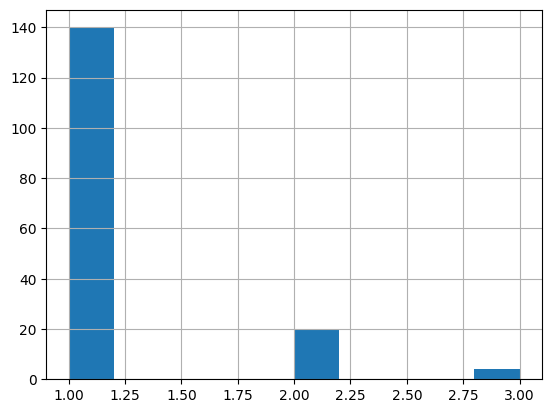

In [12]:
units_to_feats = good_pref_res.groupby("PseudoUnitID").feat.nunique().reset_index(name="num_feats")
units_to_feats.num_feats.hist()

In [13]:
units_more_than_one_feat = units_to_feats[units_to_feats.num_feats > 1].PseudoUnitID
units_feats = good_pref_res[good_pref_res.PseudoUnitID.isin(units_more_than_one_feat)].groupby("PseudoUnitID").feat.agg(list).reset_index(name="shared_feats")

In [14]:
import itertools
within_count = 0
across_count = 0
for i, row in units_feats.iterrows():
    for feat1, feat2 in itertools.combinations(row.shared_feats, 2):
        if FEATURE_TO_DIM[feat1] == FEATURE_TO_DIM[feat2]:
            within_count += 1
        else: 
            across_count += 1

In [15]:
within_count / (within_count + across_count)

0.1875

### Visualization of pref/notpref

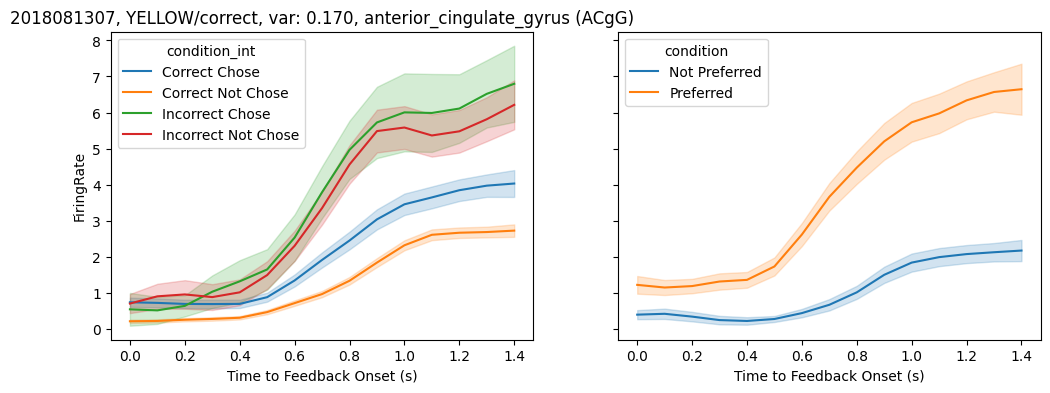

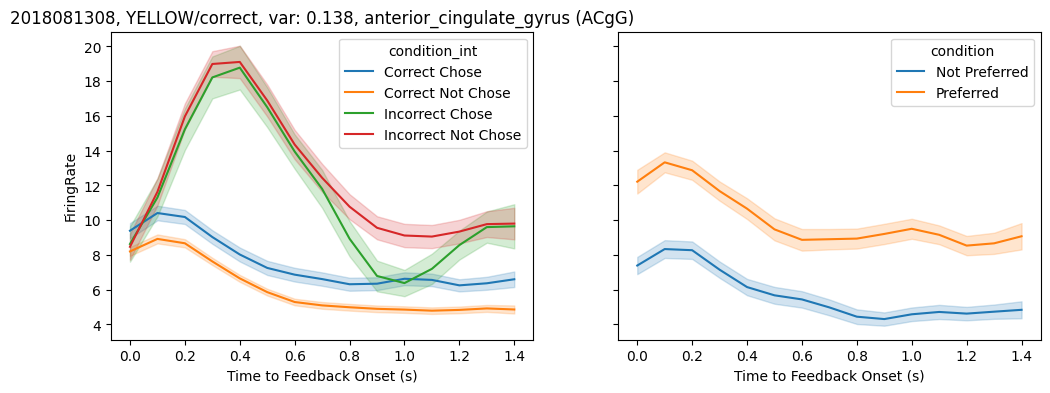

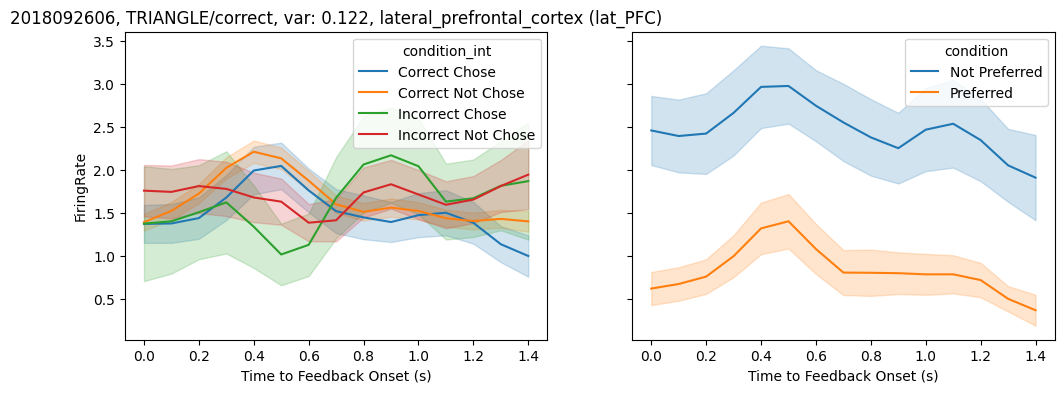

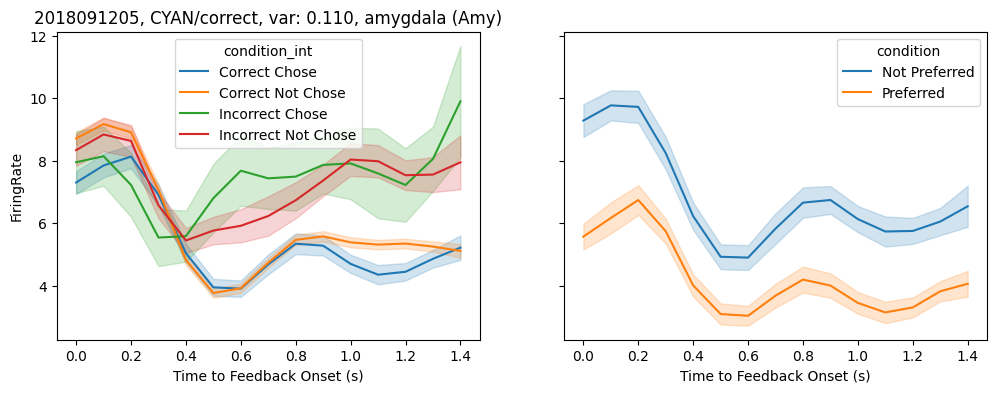

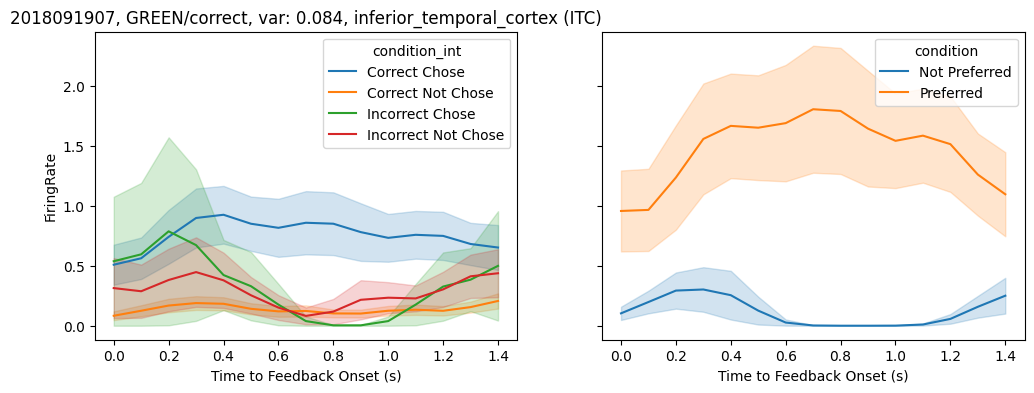

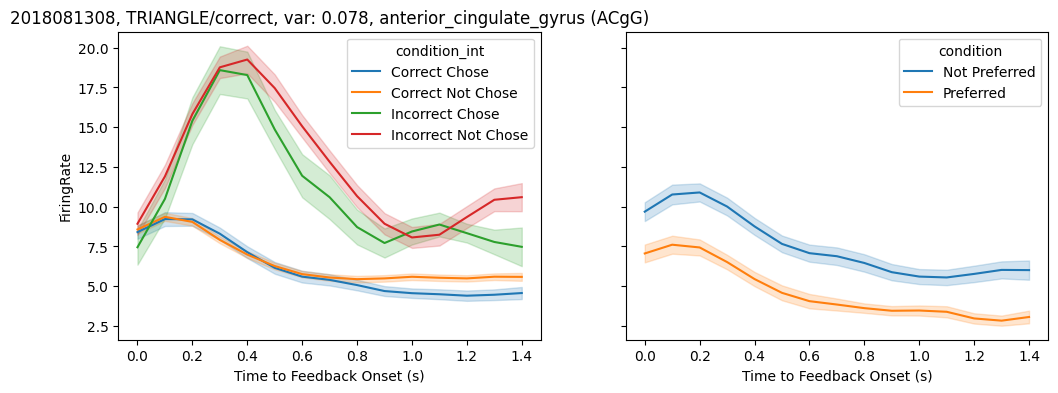

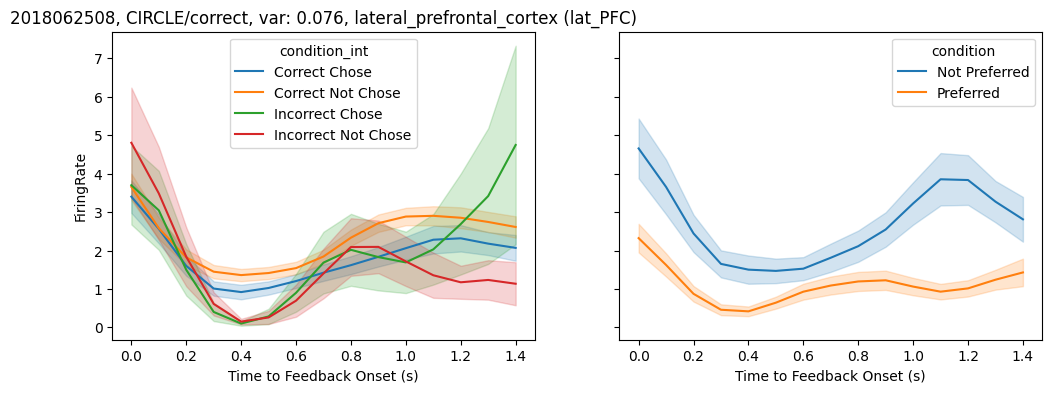

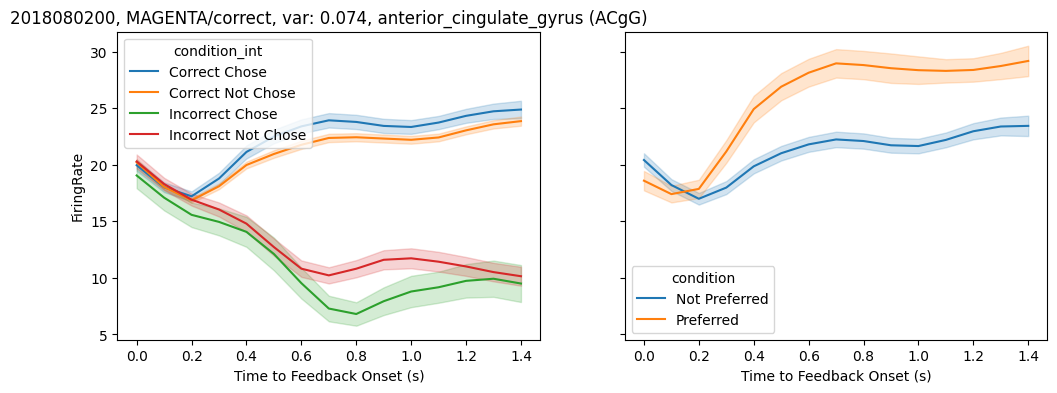

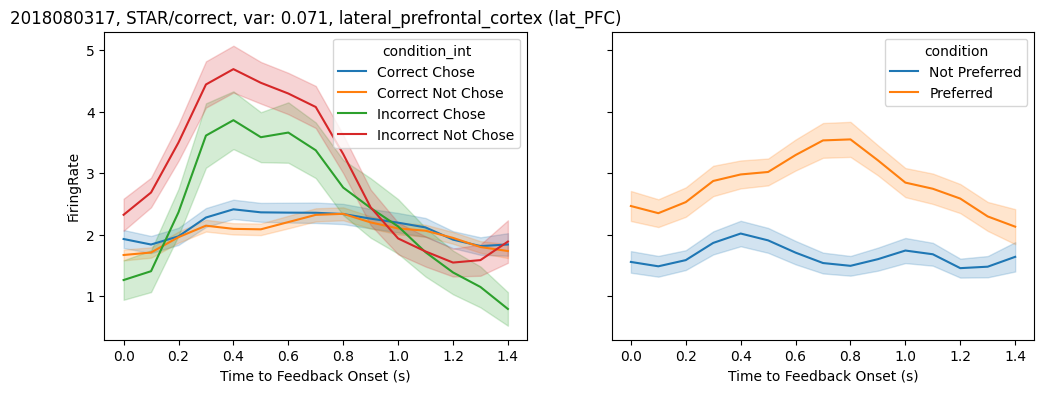

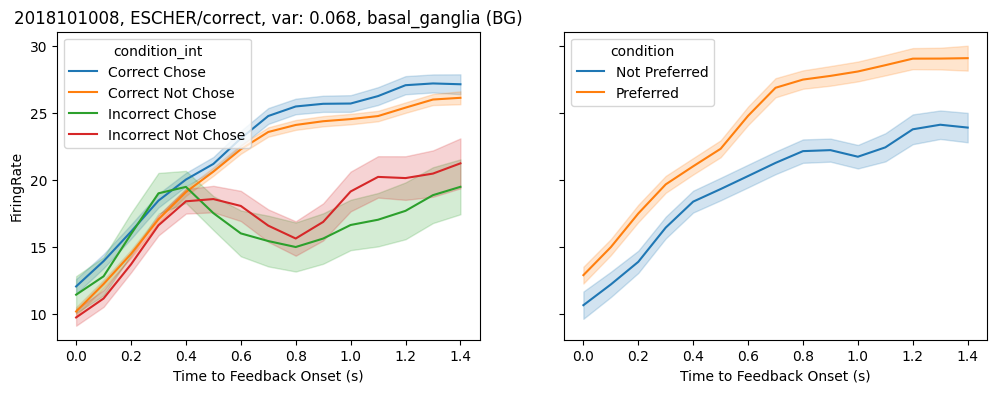

In [17]:
to_vis = good_pref_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    args.beh_filters = {"PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition_int"] = data.apply(lambda x: " ".join([x[cond] for cond in ["Response", "Choice"]]), axis=1)
    order_int = np.sort(data["condition_int"].unique())
    sns.lineplot(data, x="Time", y="FiringRate", hue="condition_int", hue_order=order_int, errorbar="se", ax=ax1)
    ax1.set_xlabel("Time to Feedback Onset (s)")

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    order = np.sort(data["condition"].unique())

    sns.lineplot(data, x="Time", y="FiringRate", hue="condition", hue_order=order, errorbar="se", ax=ax2)
    ax2.set_xlabel("Time to Feedback Onset (s)")

    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

### Pref/not pref, prior to feedback, during decision times

In [18]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1800, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_dec_res = io_utils.read_anova_good_units(args, "99th")


In [19]:
good_pref_dec_res.PseudoUnitID.nunique()

154

<Axes: >

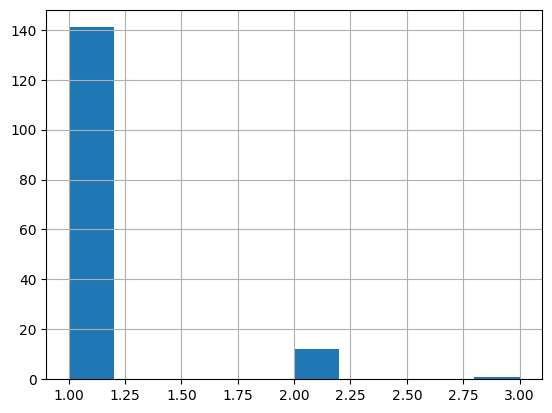

In [20]:
units_to_feats = good_pref_dec_res.groupby("PseudoUnitID").feat.nunique().reset_index(name="num_feats")
units_to_feats.num_feats.hist()

In [21]:
units_more_than_one_feat = units_to_feats[units_to_feats.num_feats > 1].PseudoUnitID
good_pref_dec_res[good_pref_dec_res.PseudoUnitID.isin(units_more_than_one_feat)].groupby("PseudoUnitID").feat.agg(list)

PseudoUnitID
2018061512             [SQUARE, SWIRL]
2018080200             [RIPPLE, SWIRL]
2018080219           [POLKADOT, SWIRL]
2018080223            [YELLOW, RIPPLE]
2018080330            [STAR, TRIANGLE]
2018080815           [SQUARE, MAGENTA]
2018080820           [POLKADOT, SWIRL]
2018081308          [TRIANGLE, YELLOW]
2018081710              [GREEN, SWIRL]
2018081714             [RIPPLE, SWIRL]
2018082817    [STAR, ESCHER, POLKADOT]
2018090402              [GREEN, SWIRL]
2018091921                [STAR, CYAN]
Name: feat, dtype: object

### Visualize pref

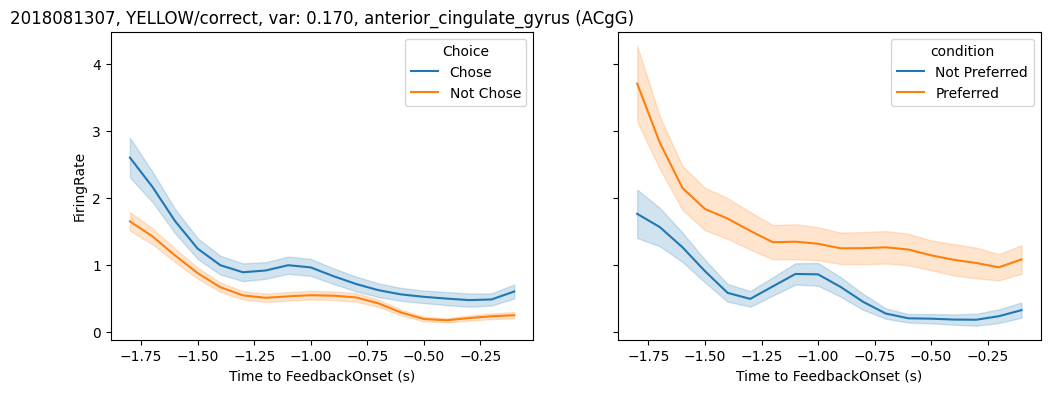

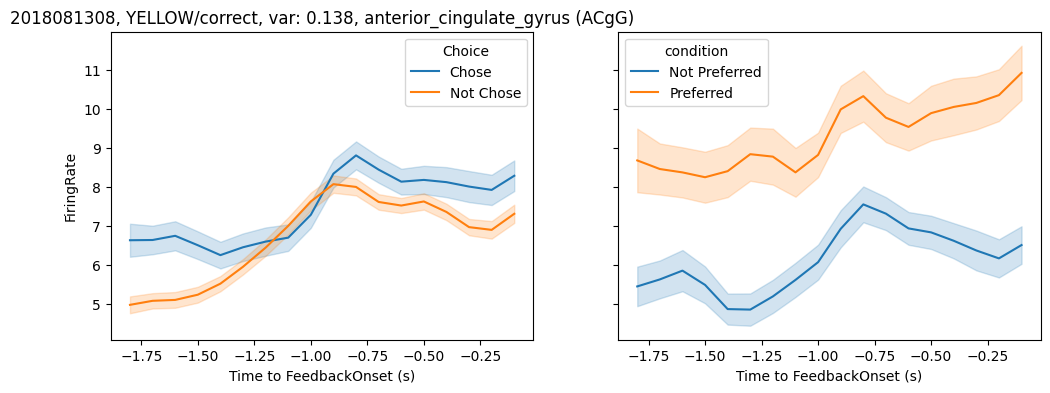

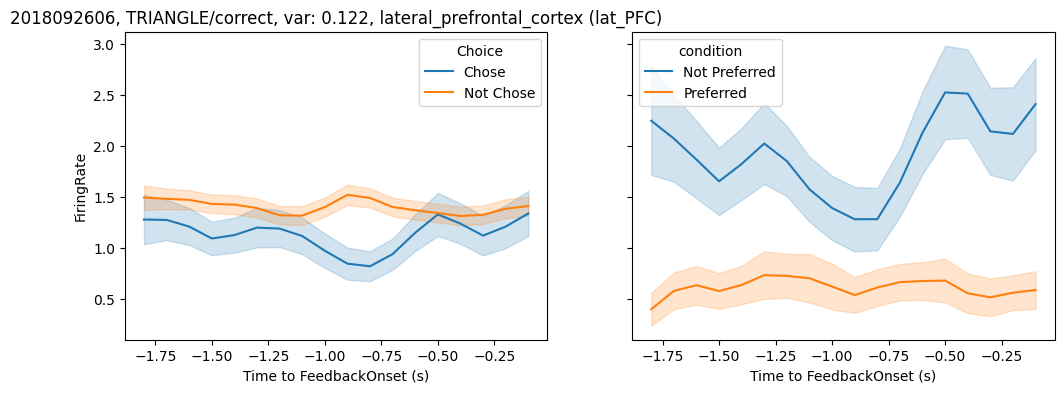

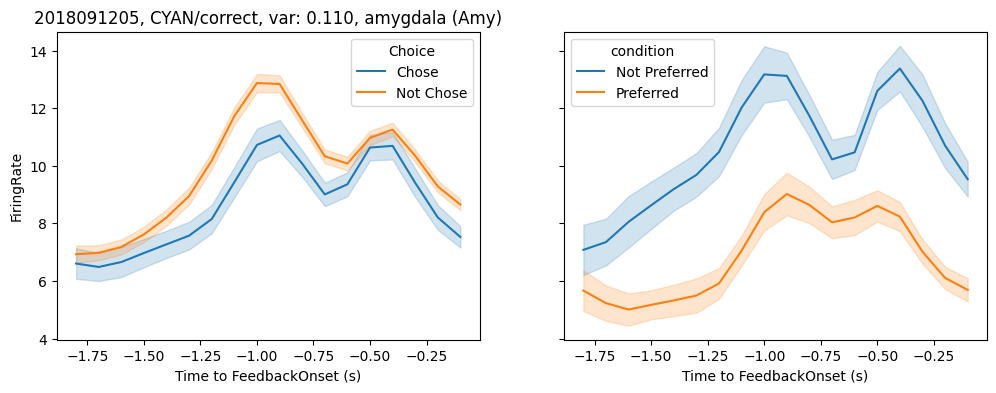

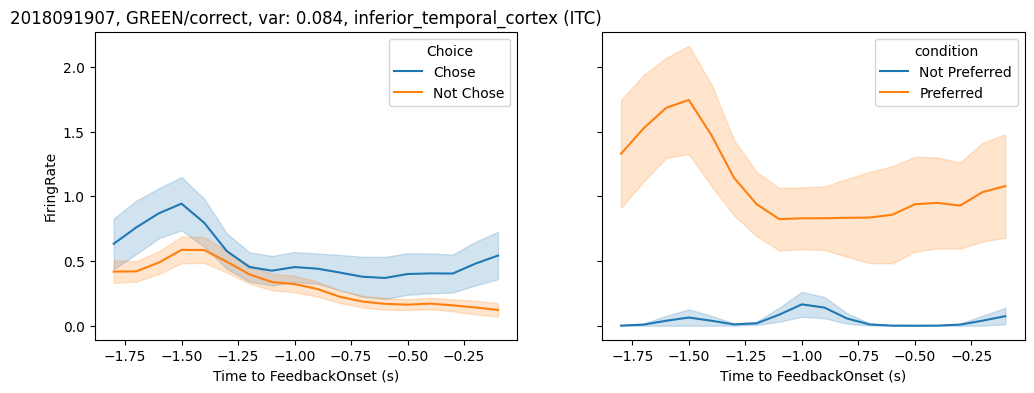

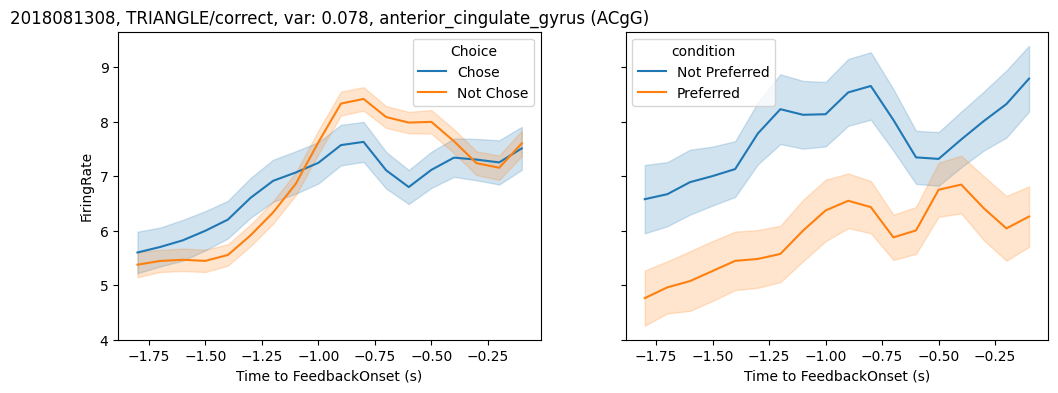

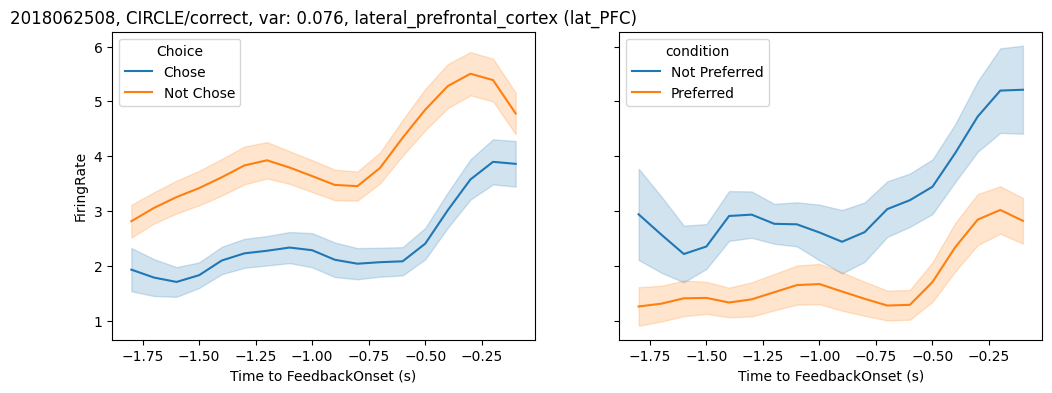

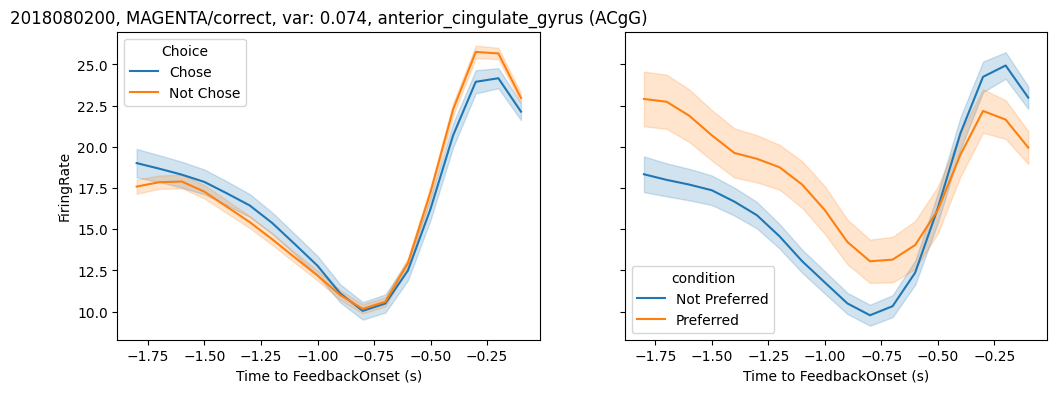

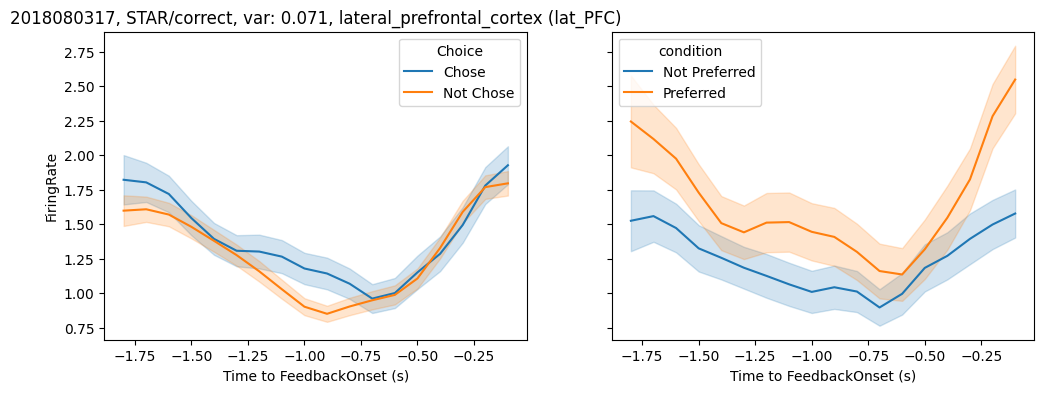

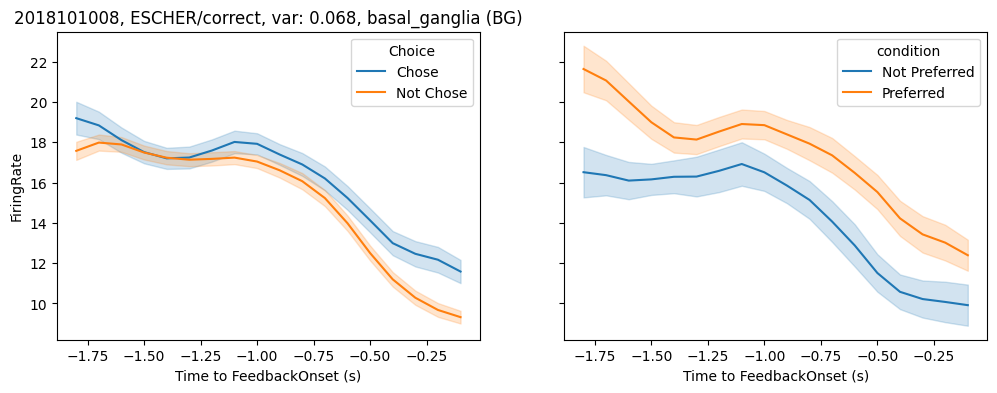

In [23]:
to_vis = good_pref_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    args.beh_filters = {"PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    choice_order = np.sort(data["Choice"].unique())
    sns.lineplot(data, x="Time", y="FiringRate", hue="Choice", hue_order=choice_order, errorbar="se", ax=ax1)
    ax1.set_xlabel("Time to FeedbackOnset (s)")

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    cond_order = np.sort(data["condition"].unique())
    sns.lineplot(data, x="Time", y="FiringRate", hue="condition", hue_order=cond_order, errorbar="se", ax=ax2)
    ax2.set_xlabel("Time to FeedbackOnset (s)")


    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

### What about prior to StimOnset

In [7]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = [-1000, 0]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_stim_res = io_utils.read_anova_good_units(args, "95th")

In [8]:
good_pref_stim_res.PseudoUnitID.nunique()
good_stim_units_by_feat = good_pref_stim_res[["PseudoUnitID", "feat"]]

In [26]:
good_pref_stim_res.PseudoUnitID.nunique()

353

In [13]:
good_stim_units_by_feat.to_pickle("/data/patrick_res/firing_rates/SA/StimOnset_pref_95th_units.pickle")

<Axes: >

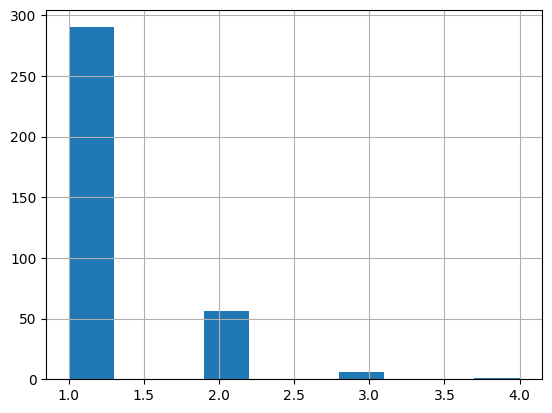

In [27]:
good_pref_stim_res.groupby("PseudoUnitID").feat.nunique().reset_index(name="num_feats").num_feats.hist()

### Visualize stim

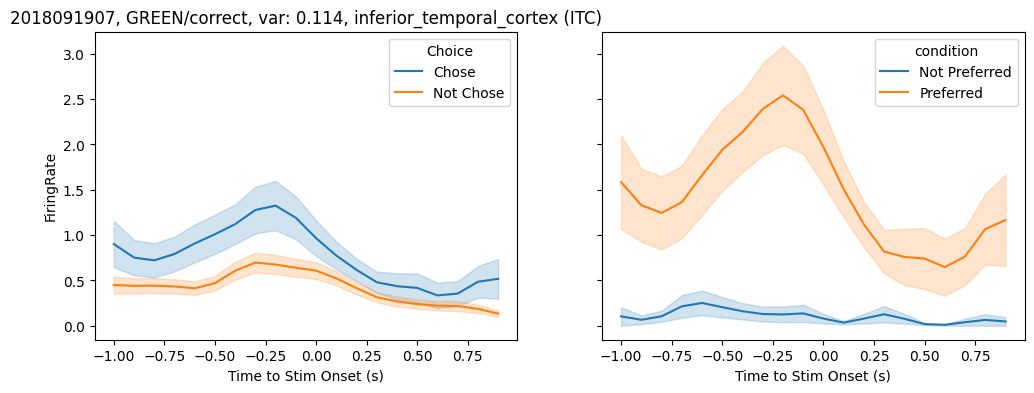

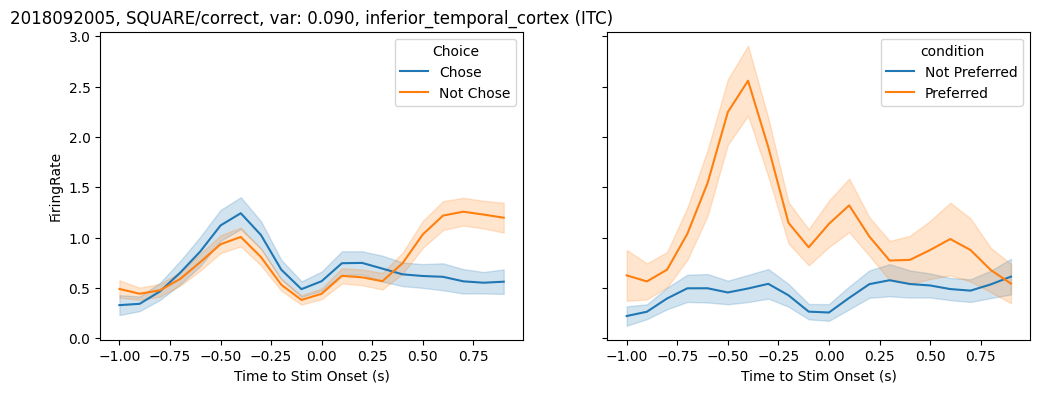

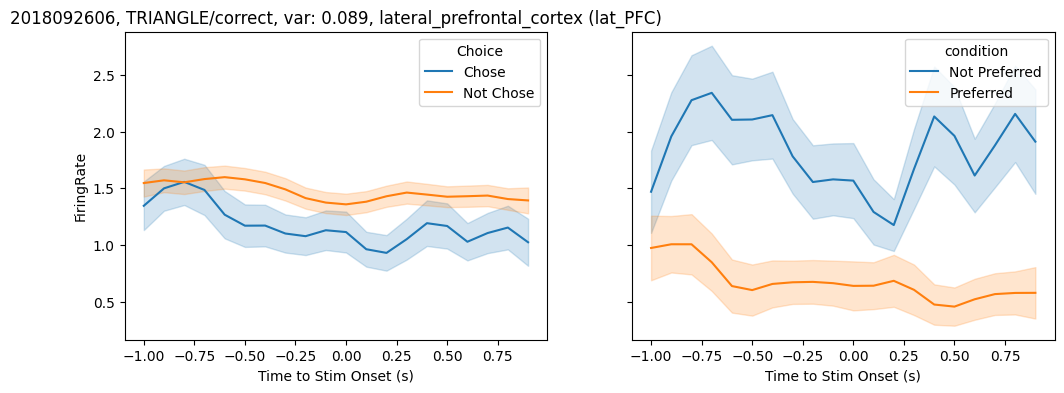

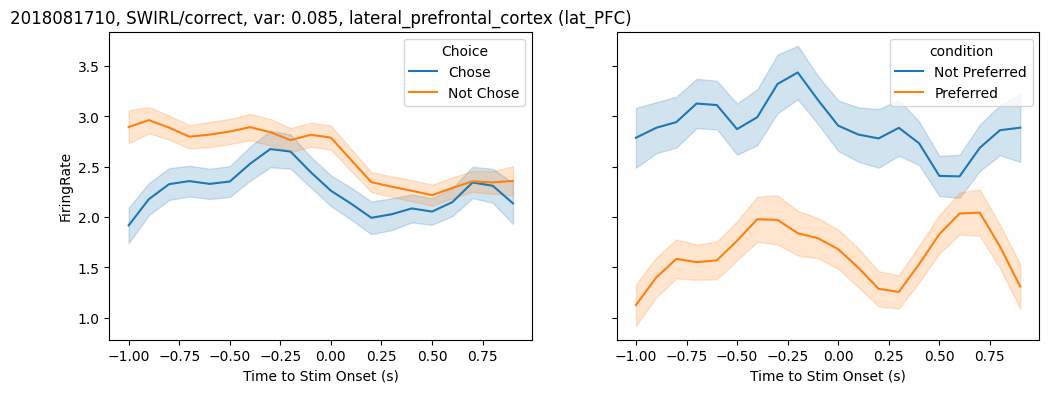

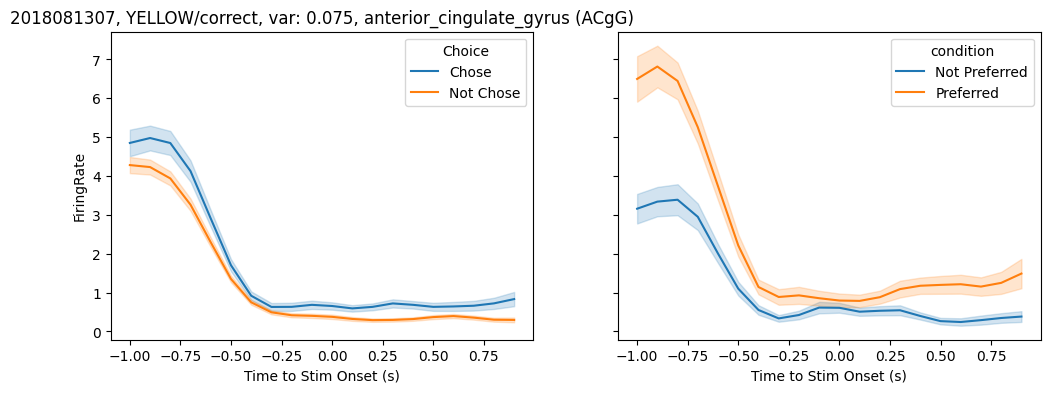

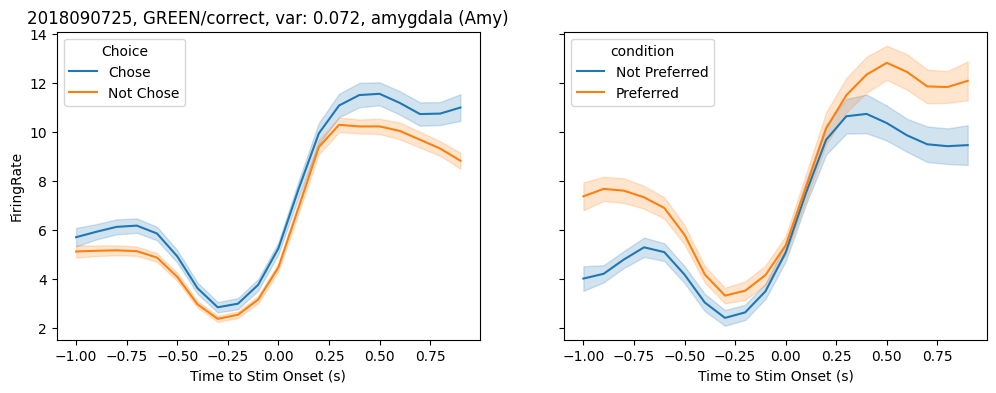

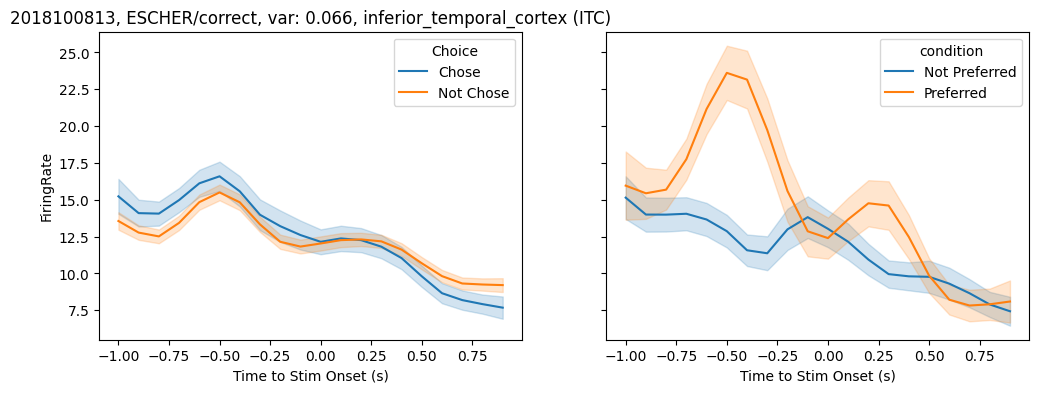

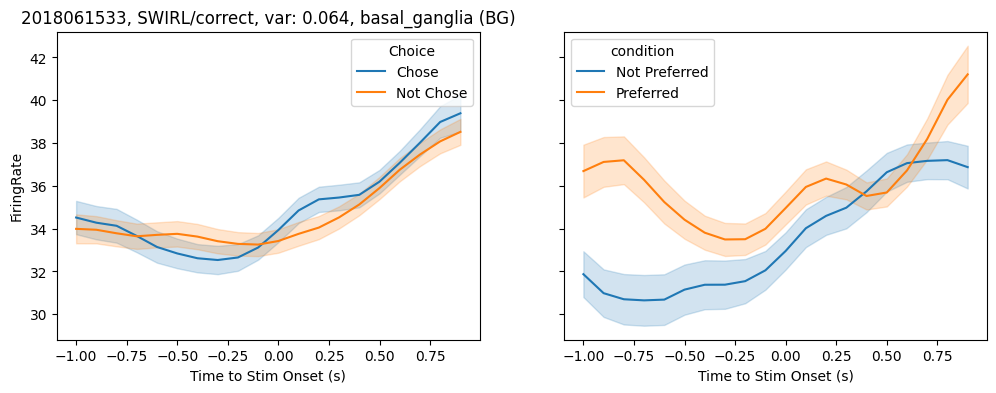

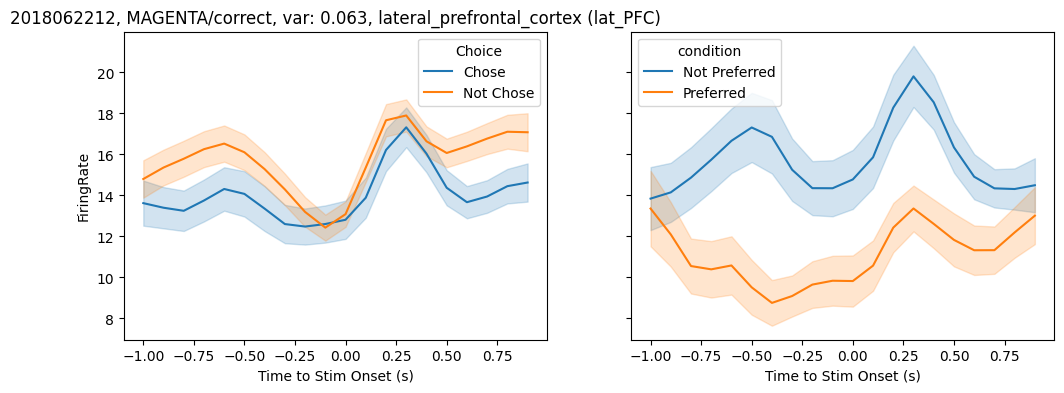

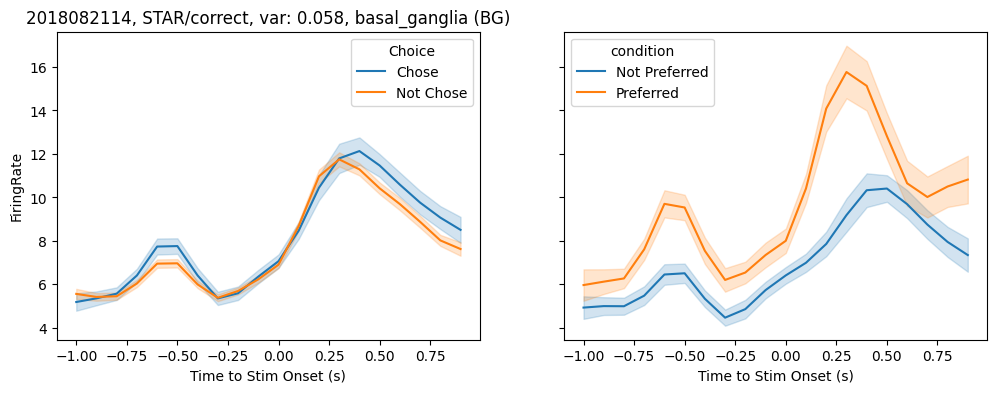

In [6]:
to_vis = good_pref_stim_res.sort_values("combined_fracvar", ascending=False)[:10]
for i, unit in to_vis.iterrows():
    unit_id = int(unit.PseudoUnitID)
    args.feat = unit.feat
    args.time_range = None

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    args.beh_filters = {"PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    choice_order = np.sort(data["Choice"].unique())
    sns.lineplot(data, x="Time", y="FiringRate", hue="Choice", hue_order=choice_order, errorbar="se", ax=ax1)
    ax1.set_xlabel("Time to Stim Onset (s)")

    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    data = load_data(int(unit_id / 100), args)
    data = data[data.PseudoUnitID == unit_id]
    data["condition"] = data.apply(lambda x: "".join([x[cond] for cond in args.conditions]), axis=1)
    cond_order = np.sort(data["condition"].unique())

    sns.lineplot(data, x="Time", y="FiringRate", hue="condition", hue_order=cond_order, errorbar="se", ax=ax2)
    ax2.set_xlabel("Time to Stim Onset (s)")


    ax1.set_title(f"{unit_id}, {unit.feat}/correct, var: {unit.combined_fracvar:.3f}, {unit.structure_level2}")

### 1s before/after StimOnset

In [9]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "StimOnset"
args.conditions = ["FeatPreferred"]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_stim_res_all = io_utils.read_anova_good_units(args, "95th")

In [10]:
good_pref_stim_res_all.PseudoUnitID.nunique()

358

In [11]:
good_pref_stim_res_all[good_pref_stim_res_all.PseudoUnitID.isin(good_pref_stim_res.PseudoUnitID)].PseudoUnitID.nunique()

232

In [8]:
good_pref_stim_res_all[["PseudoUnitID", "feat"]].to_pickle("/data/patrick_res/firing_rates/SA/StimOnset_pref_95th_all_time_units.pickle")

### All timepoints of FeedbackOnset

In [13]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.conditions = ["FeatPreferred"]
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
good_pref_all_res = io_utils.read_anova_good_units(args, "95th")


In [15]:
good_pref_all_res.groupby("feat").PseudoUnitID.nunique()

feat
CIRCLE      48
CYAN        43
ESCHER      32
GREEN       33
MAGENTA     46
POLKADOT    27
RIPPLE      37
SQUARE      53
STAR        34
SWIRL       38
TRIANGLE    46
YELLOW      60
Name: PseudoUnitID, dtype: int64

In [16]:
good_pref_all_res[["PseudoUnitID", "feat"]].to_pickle("/data/patrick_res/firing_rates/SA/FeedbackOnsetLong_pref_95th_all_time_units.pickle")

### During feedback, are all preference selective units also interaction-selective?

In [108]:
good_int_res.PseudoUnitID.nunique()

455

In [109]:
good_pref_res.PseudoUnitID.nunique()

386

In [110]:
shared = good_pref_res[good_pref_res.PseudoUnitID.isin(good_int_res.PseudoUnitID)]

In [111]:
shared.PseudoUnitID.nunique()

170

### Are preference selective neurons during feedback also preference selective during decision making?

In [112]:
good_pref_res.PseudoUnitID.nunique()

386

In [113]:
good_pref_dec_res.PseudoUnitID.nunique()

372

In [114]:
shared_pref = good_pref_res[good_pref_res.PseudoUnitID.isin(good_pref_dec_res.PseudoUnitID)]

In [115]:
len(shared_pref)

229

### Test: what is probability of getting within/across dimension pair of features?

In [37]:
import itertools
within_count = 0
across_count = 0
for feat1, feat2 in list(itertools.product(FEATURES, FEATURES)):
    if feat1 != feat2: 
        if FEATURE_TO_DIM[feat1] == FEATURE_TO_DIM[feat2]:
            within_count += 1
        else: 
            across_count += 1

In [38]:
within_count / (across_count + within_count)

0.2727272727272727

### Plot percentage of units by region: 

In [16]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))

Number of total units by structure_level2:

In [17]:
region_totals = unit_pos.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="num_total")
region_totals = region_totals[region_totals.num_total > 12]


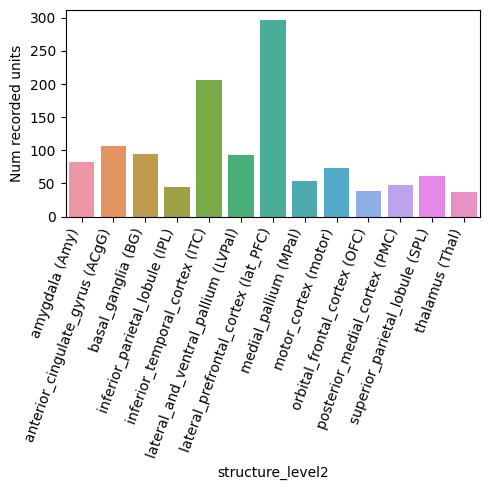

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(region_totals, x="structure_level2", y="num_total", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.set_ylabel("Num recorded units")
fig.tight_layout()

In [19]:
int_by_region = good_int_res.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="selective")
int_by_region = pd.merge(int_by_region, region_totals, on="structure_level2")
int_by_region["% units"] = int_by_region.selective / int_by_region.num_total * 100

pref_by_region = good_pref_res.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="selective")
pref_by_region = pd.merge(pref_by_region, region_totals, on="structure_level2")
pref_by_region["% units"] = pref_by_region.selective / int_by_region.num_total * 100


pref_dec_by_region = good_pref_dec_res.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="selective")
pref_dec_by_region = pd.merge(pref_dec_by_region, region_totals, on="structure_level2")
pref_dec_by_region["% units"] = pref_dec_by_region.selective / int_by_region.num_total * 100

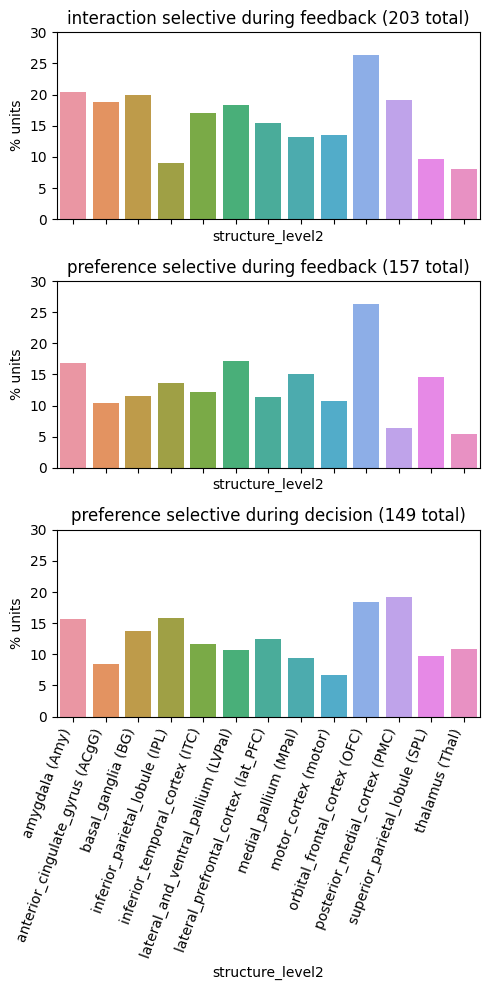

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
sns.barplot(int_by_region, x="structure_level2", y="% units", ax=ax1)
ax1.set_title(f"interaction selective during feedback ({int_by_region.selective.sum()} total)")
ax1.set_ylim([0, 30])

sns.barplot(pref_by_region, x="structure_level2", y="% units", ax=ax2)
ax2.set_title(f"preference selective during feedback ({pref_by_region.selective.sum()} total)")
ax2.set_ylim([0, 30])

sns.barplot(pref_dec_by_region, x="structure_level2", y="% units", ax=ax3)
ax3.set_title(f"preference selective during decision ({pref_dec_by_region.selective.sum()} total)")
ax3.set_ylim([0, 30])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=70, ha='right')
fig.tight_layout()

In [141]:
good_pref_stim_res.groupby("feat").PseudoUnitID.nunique()

feat
CIRCLE      53
CYAN        41
ESCHER      27
GREEN       39
MAGENTA     42
POLKADOT    30
RIPPLE      35
SQUARE      35
STAR        23
SWIRL       32
TRIANGLE    27
YELLOW      40
Name: PseudoUnitID, dtype: int64